In [1]:
import pandas as pd, numpy as np
import requests
import json
import os
import time

In [2]:
# Cufflinks wrapper on plotly
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from plotly.offline import iplot
cufflinks.go_offline()

# Set global theme

import plotly.figure_factory as ff

import plotly.graph_objects as go

In [177]:
import plotly.express as px
from shapely.geometry import Polygon, MultiPolygon
import geopandas as gpd
import matplotlib.pyplot as plt
import geojsoncontour

from scipy.interpolate import griddata
from numpy import linspace

# Extracting restaurant data

In [136]:
df=pd.read_excel("RE_models_input.xlsx")

In [4]:
df.district

0             Wola
1             Wola
2             Wola
3             Wola
4             Wola
           ...    
11783    Bialoleka
11784    Bialoleka
11785      Wilanow
11786     Subburbs
11787        Praga
Name: district, Length: 11788, dtype: object

In [5]:
df_grid=df.groupby(['lat_mod', 'lon_mod'], as_index=False).first()[['lat_mod', 'lon_mod',"district"]]

In [6]:
coors_arr=df_grid[['lat_mod', 'lon_mod']].values

In [8]:
coordinates=[]
for i in range(0, coors_arr.shape[0]):
    coor_point=str(coors_arr[i,0])+", "+str(coors_arr[i,1])
    coordinates.append(coor_point)

In [9]:
coordinate = '52.1175, 21.0000'
keyword = 'restaurant'
radius=750

In [10]:
api_key = open("Api_key.txt", "r").read()

In [11]:
import googlemaps
from datetime import datetime

gmaps = googlemaps.Client(key=api_key)


In [12]:
coordinates[:1]

['52.0725, 21.015']

In [31]:
json_list=[]
i=0
for coordinate in coordinates:
    i+=1
    
    url = 'https://maps.googleapis.com/maps/api/place/nearbysearch/json?location='+coordinate+'&radius='+str(radius)+'&keyword='+str(keyword)+'&key='+str(api_key)
    
    while True:

        response = requests.get(url)
        datapage = json.loads(response.text)
        json_list=json_list+datapage["results"]
        time.sleep(10)

        if 'next_page_token' not in datapage:
            break
        else:

            next_page_token = datapage['next_page_token']

            url = 'https://maps.googleapis.com/maps/api/place/nearbysearch/json?key='+str(api_key)+'&pagetoken='+str(next_page_token)
        
    if np.mod(i,10)==0:
        print("Extracted {} offers from {} grids at {}".format(len(json_list),i,str(datetime.now())[:-7]))


    

Extracted 76 offers from 10 grids at 2020-06-22 22:11:21
Extracted 205 offers from 20 grids at 2020-06-22 22:13:44
Extracted 527 offers from 30 grids at 2020-06-22 22:17:13
Extracted 773 offers from 40 grids at 2020-06-22 22:20:22
Extracted 986 offers from 50 grids at 2020-06-22 22:23:07
Extracted 1139 offers from 60 grids at 2020-06-22 22:25:42
Extracted 1324 offers from 70 grids at 2020-06-22 22:28:43
Extracted 1622 offers from 80 grids at 2020-06-22 22:32:04
Extracted 1827 offers from 90 grids at 2020-06-22 22:34:49
Extracted 2012 offers from 100 grids at 2020-06-22 22:37:24
Extracted 2285 offers from 110 grids at 2020-06-22 22:40:33
Extracted 2429 offers from 120 grids at 2020-06-22 22:42:46
Extracted 2699 offers from 130 grids at 2020-06-22 22:46:18
Extracted 2889 offers from 140 grids at 2020-06-22 22:49:03
Extracted 3268 offers from 150 grids at 2020-06-22 22:53:05
Extracted 3364 offers from 160 grids at 2020-06-22 22:55:16
Extracted 3706 offers from 170 grids at 2020-06-22 22:5

In [32]:
np.mod(4,3)

1

In [33]:
len(json_list)

9190

## Saving extracted data to local file

In [34]:
#Saving list of jsons as a txt file

directory="./Warsaw_restaurant_data/"
if not os.path.exists(directory):
    os.makedirs(directory)
    
todaydate =   str(datetime.now())[:10]+"_"+str(datetime.now().hour)+str(datetime.now().minute)
file_name=directory+"Restaurants_"+todaydate+".txt"
file_name

'./Warsaw_restaurant_data/Restaurants_2020-06-23_09.txt'

In [35]:
 str(datetime.now())[:10]+"_"+str(datetime.now().hour)+str(datetime.now().minute)

'2020-06-23_09'

In [36]:
text_file = open(file_name, "w")
text_file.write(json.dumps(json_list))
text_file.close()

10566867

In [5]:
file_name='./Warsaw_restaurant_data/Restaurants_2020-06-23_09.txt'

In [74]:
#Opening same file and converting it into a json list
json_list_txt = open(file_name, "r").read()
restaurants_json_txt=json.loads(json_list_txt)

## Transforming data from json to dataframe

In [87]:
restaurants_json=json.dumps(restaurants_json_txt)
df_restaurants=pd.read_json(restaurants_json, orient='name')

df_restaurants.columns

Index(['business_status', 'geometry', 'icon', 'id', 'name', 'opening_hours',
       'photos', 'place_id', 'plus_code', 'price_level', 'rating', 'reference',
       'scope', 'types', 'user_ratings_total', 'vicinity',
       'permanently_closed'],
      dtype='object')

In [88]:
df_restaurants["lat"]=df_restaurants.geometry.apply(lambda x:x["location"]["lat"])
df_restaurants["lon"]=df_restaurants.geometry.apply(lambda x:x["location"]["lng"])


In [89]:
df_restaurants.columns

Index(['business_status', 'geometry', 'icon', 'id', 'name', 'opening_hours',
       'photos', 'place_id', 'plus_code', 'price_level', 'rating', 'reference',
       'scope', 'types', 'user_ratings_total', 'vicinity',
       'permanently_closed', 'lat', 'lon'],
      dtype='object')

In [90]:
df_restaurants.shape

(9190, 19)

In [91]:
df_restaurants.head()

,business_status,geometry,icon,id,name,opening_hours,photos,place_id,plus_code,price_level,rating,reference,scope,types,user_ratings_total,vicinity,permanently_closed,lat,lon
0,OPERATIONAL,"{'location': {'lat': 52.0708962, 'lng': 21.023...",https://maps.gstatic.com/mapfiles/place_api/ic...,d6d17f35ea376b9490d8d6782708ff1961c08674,Restauracja Odjazd,{'open_now': True},"[{'height': 4248, 'html_attributions': ['<a hr...",ChIJB8GapkcuGUcRWfE7RhtdOYg,"{'compound_code': '32CF+9F Piaseczno', 'global...",2.0,4.2,ChIJB8GapkcuGUcRWfE7RhtdOYg,GOOGLE,"[restaurant, food, point_of_interest, establis...",152,"Henryka Sienkiewicza 14, Piaseczno",NaN,52.070896,21.023734
1,OPERATIONAL,"{'location': {'lat': 52.0778201, 'lng': 21.025...",https://maps.gstatic.com/mapfiles/place_api/ic...,5709b3d1730712fe7a366b8eb6a1d89c540b0c9b,Meninx Kebab,{'open_now': True},"[{'height': 4160, 'html_attributions': ['<a hr...",ChIJwx4cjD8uGUcRUu0he0X4jxo,"{'compound_code': '32HG+48 Piaseczno', 'global...",1.0,4.3,ChIJwx4cjD8uGUcRUu0he0X4jxo,GOOGLE,"[restaurant, food, point_of_interest, establis...",608,"Młynarska 1, Piaseczno",NaN,52.077820,21.025825
2,OPERATIONAL,"{'location': {'lat': 52.0731019, 'lng': 21.022...",https://maps.gstatic.com/mapfiles/place_api/ic...,7807fb359cb1b2a738a6cf46862409c4fb6fcd10,Domino's pizza,{'open_now': True},"[{'height': 3120, 'html_attributions': ['<a hr...",ChIJW6aDnzguGUcRaeIqzIMJaFQ,"{'compound_code': '32FF+63 Piaseczno', 'global...",2.0,3.9,ChIJW6aDnzguGUcRaeIqzIMJaFQ,GOOGLE,"[restaurant, food, point_of_interest, establis...",173,"Wojska Polskiego 28, Piaseczno",NaN,52.073102,21.022638
3,OPERATIONAL,"{'location': {'lat': 52.072261, 'lng': 21.0227...",https://maps.gstatic.com/mapfiles/place_api/ic...,a88ee3a6681ccf279eac0ae16db3dadea11343f0,Telepizza - pizza Piaseczno,{'open_now': True},"[{'height': 4140, 'html_attributions': ['<a hr...",ChIJF-Cj0mouGUcRB-y1wjmBGyI,"{'compound_code': '32CF+W4 Piaseczno', 'global...",2.0,3.9,ChIJF-Cj0mouGUcRB-y1wjmBGyI,GOOGLE,"[meal_delivery, meal_takeaway, restaurant, foo...",230,"Wojska Polskiego 30, Piaseczno",NaN,52.072261,21.022789
4,OPERATIONAL,"{'location': {'lat': 52.0691865, 'lng': 21.016...",https://maps.gstatic.com/mapfiles/place_api/ic...,ea803fa6d10d7a610b9fcf473d3e93950b3ac10d,"Curry King Restauracja Indyjska, Continental i...",{'open_now': False},"[{'height': 4032, 'html_attributions': ['<a hr...",ChIJ4TyGNDUuGUcRTSUAbBF-YRw,"{'compound_code': '3298+MH Piaseczno', 'global...",2.0,4.6,ChIJ4TyGNDUuGUcRTSUAbBF-YRw,GOOGLE,"[bar, restaurant, food, point_of_interest, est...",866,"Dworcowa 17, Piaseczno",NaN,52.069187,21.016433


In [92]:
df_restaurants=df_restaurants[['name',  'place_id', 'price_level','rating', 'user_ratings_total', 'vicinity', 'lat', 'lon']]


In [93]:
df_restaurants.price_level.unique()

array([ 2.,  1., nan,  3.,  4.])

In [94]:
df_restaurants.isna().sum()

name                     0
place_id                 0
price_level           3934
rating                   0
user_ratings_total       0
vicinity                 0
lat                      0
lon                      0
dtype: int64

In [95]:
df_restaurants=df_restaurants.dropna(subset=['rating', 'user_ratings_total','lat', 'lon'])

In [96]:

df_restaurants.shape

(9190, 8)

In [97]:
df_restaurants=df_restaurants.drop_duplicates()

In [98]:
df_restaurants.shape

(3263, 8)

## Visualizing extracted data 

In [99]:
#Selecting a central city point to center all graphs around - Swietokrzyska Subway 
center_coors=52.235176, 21.008393

In [100]:
data=[]
trace0=go.Scattermapbox(
            lat=df_restaurants.lat,
            lon=df_restaurants.lon,
          
            mode='markers',
            marker=dict(
                opacity=0.5, 
                size=10, 
                color=df_restaurants.rating,
               
                colorscale="jet",
                cauto=False,
                cmax=5,
                cmin=4,
                showscale=True),
                text=df_restaurants.rating,
            
           
            )



data=[trace0]

layout = go.Layout(
    title="Restaurant rating (0-5)",  
    title_x=0.4,
   
    
    
    height = 800,
    # top, bottom, left and right margins
    margin = dict(t = 80, b = 0, l = 0, r = 0),
    font = dict(color = 'dark grey', size = 18),
 
    mapbox = dict(
       

        center = dict(
            lat = center_coors[0],
            lon = center_coors[1]
        ),
        # default level of zoom
        zoom = 10,
        # default map style
        style = "carto-positron"
    )

)

figure=go.Figure(
    data=data,
    layout=layout,
  
    )



iplot(figure)

In [101]:
data=[]
trace0=go.Scattermapbox(
            lat=df_restaurants.lat,
            lon=df_restaurants.lon,
          
            mode='markers',
            marker=dict(
                opacity=0.5, 
                size=10, 
                color=df_restaurants.user_ratings_total,
               
                colorscale="jet",
                cauto=False,
                cmax=1000,
                showscale=True),
                text=df_restaurants.user_ratings_total,
           
            )



data=[trace0]

layout = go.Layout(
    title="Restaurant popularity [ratings count]",  
    title_x=0.4,
   
    
    
    height = 800,
    # top, bottom, left and right margins
    margin = dict(t = 80, b = 0, l = 0, r = 0),
    font = dict(color = 'dark grey', size = 18),
 
    mapbox = dict(
       

        center = dict(
            lat = center_coors[0],
            lon = center_coors[1]
        ),
        # default level of zoom
        zoom = 10,
        # default map style
        style = "carto-positron"
    )

)

figure=go.Figure(
    data=data,
    layout=layout,
  
    )



iplot(figure)

In [119]:
data=[]
trace0=go.Scattermapbox(
            lat=df_restaurants.lat,
            lon=df_restaurants.lon,
          
            mode='markers',
            marker=dict(
                opacity=0.5, 
                size=10, 
                color=df_restaurants.price_level,
               
                colorscale="jet",
                cauto=False,
                cmax=4,
                showscale=True),
                text=df_restaurants.price_level,
           
            )



data=[trace0]

layout = go.Layout(
    title="Restaurant pricing [1-4]",  
    title_x=0.4,
   
    
    
    height = 800,
    # top, bottom, left and right margins
    margin = dict(t = 80, b = 0, l = 0, r = 0),
    font = dict(color = 'dark grey', size = 18),
 
    mapbox = dict(
       

        center = dict(
            lat = center_coors[0],
            lon = center_coors[1]
        ),
        # default level of zoom
        zoom = 10,
        # default map style
        style = "carto-positron"
    )

)

figure=go.Figure(
    data=data,
    layout=layout,
  
    )



iplot(figure)

# Grouping data into grid

In [201]:
rounding_num=0.015 #roundign coordinates by chosen precision creates a grid
df_restaurants["lon_mod"]=np.round(df_restaurants.lon/rounding_num,0)*rounding_num
correction_coeff=0.5

df_restaurants["lat_mod"]=np.round(df_restaurants.lat/(rounding_num*correction_coeff),0)*(rounding_num*correction_coeff)
df_restaurants["lon_mod"]=np.round(df_restaurants["lon_mod"],4)
df_restaurants["lat_mod"]=np.round(df_restaurants["lat_mod"],4)

In [202]:
# Creating grid dataframe with average unit prices for each tile. Excluding tiles with sample below 3 as insufficient samples. 
df_map=df_restaurants[["lat_mod","lon_mod","price_level","rating",'user_ratings_total']].groupby(["lat_mod","lon_mod"], as_index=False).mean()
df_map["sample_size"]=df_restaurants[["lat_mod","lon_mod","place_id"]].groupby(["lat_mod","lon_mod"], as_index=False).count().place_id

In [203]:
df_map=df_map.query("sample_size>5")
df_map.reset_index(inplace=True,drop=True)

In [204]:
df_map

,lat_mod,lon_mod,price_level,rating,user_ratings_total,sample_size
0,52.0725,21.015,1.666667,3.890000,316.700000,10
1,52.0725,21.030,1.727273,4.081250,184.937500,16
2,52.1025,21.030,1.666667,3.342857,217.571429,7
3,52.1250,21.015,2.000000,3.600000,1234.666667,6
4,52.1325,21.060,1.814815,4.205128,388.897436,39
...,...,...,...,...,...,...
176,52.3200,21.015,1.000000,4.385714,28.571429,7
177,52.3200,21.060,1.500000,4.363636,219.363636,11
178,52.3275,20.940,1.800000,4.200000,195.375000,8
179,52.3350,20.940,2.000000,4.171429,233.428571,7


In [205]:
df_map.isna().sum()

lat_mod               0
lon_mod               0
price_level           2
rating                0
user_ratings_total    0
sample_size           0
dtype: int64

## Grid visualization

In [206]:
data=[]
trace0=go.Scattermapbox(
            lat=df_map.lat_mod,
            lon=df_map.lon_mod,
          
            mode='markers',
            marker=dict(
                opacity=0.5, 
                size=20, 
                color=df_map.rating,
               
                colorscale="jet",
                cauto=False,
                cmax=5,
                cmin=4,
                showscale=True),
                text=df_map.rating,
            
           
            )



data=[trace0]

layout = go.Layout(
    title="Restaurant rating (0-5)",  
    title_x=0.4,
   
    
    
    height = 800,
    # top, bottom, left and right margins
    margin = dict(t = 80, b = 0, l = 0, r = 0),
    font = dict(color = 'dark grey', size = 18),
 
    mapbox = dict(
       

        center = dict(
            lat = center_coors[0],
            lon = center_coors[1]
        ),
        # default level of zoom
        zoom = 10,
        # default map style
        style = "carto-positron"
    )

)

figure=go.Figure(
    data=data,
    layout=layout,
  
    )



iplot(figure)

In [207]:
data=[]
trace0=go.Scattermapbox(
            lat=df_map.lat_mod,
            lon=df_map.lon_mod,
          
            mode='markers',
            marker=dict(
                opacity=0.5, 
                size=20, 
                color=df_map.user_ratings_total,
               
                colorscale="jet",
                cauto=False,
                cmax=1000,
                cmin=100,
                showscale=True),
                text=df_map.user_ratings_total,
            
           
            )



data=[trace0]

layout = go.Layout(
    title="Restaurant popularity",  
    title_x=0.4,
   
    
    
    height = 800,
    # top, bottom, left and right margins
    margin = dict(t = 80, b = 0, l = 0, r = 0),
    font = dict(color = 'dark grey', size = 18),
 
    mapbox = dict(
       

        center = dict(
            lat = center_coors[0],
            lon = center_coors[1]
        ),
        # default level of zoom
        zoom = 10,
        # default map style
        style = "carto-positron"
    )

)

figure=go.Figure(
    data=data,
    layout=layout,
  
    )



iplot(figure)

In [208]:
data=[]
trace0=go.Scattermapbox(
            lat=df_map.lat_mod,
            lon=df_map.lon_mod,
          
            mode='markers',
            marker=dict(
                opacity=0.5, 
                size=20, 
                color=df_map.sample_size,
               
                colorscale="jet",
                cauto=False,
                cmax=60,
                cmin=0,
                showscale=True),
                text=df_map.sample_size,
            
           
            )



data=[trace0]

layout = go.Layout(
    title="Restaurants count",  
    title_x=0.4,
   
    
    
    height = 800,
    # top, bottom, left and right margins
    margin = dict(t = 80, b = 0, l = 0, r = 0),
    font = dict(color = 'dark grey', size = 18),
 
    mapbox = dict(
       

        center = dict(
            lat = center_coors[0],
            lon = center_coors[1]
        ),
        # default level of zoom
        zoom = 10,
        # default map style
        style = "carto-positron"
    )

)

figure=go.Figure(
    data=data,
    layout=layout,
  
    )



iplot(figure)

In [209]:
df_map.columns

Index(['lat_mod', 'lon_mod', 'price_level', 'rating', 'user_ratings_total',
       'sample_size'],
      dtype='object')

In [210]:
df_map.rename(columns={
    "sample_size":"restaurant_count",
    'price_level':"restaurant_price_level",
    'rating':"restaurant_mean_rating",
    'user_ratings_total':"restaurant_mean_popularity"
    


},inplace=True)

In [211]:
df_enriched=pd.merge(df,df_map,on=["lat_mod","lon_mod"],how="left")

In [212]:
df.shape

(11788, 66)

In [213]:
df_enriched.shape

(11788, 70)

In [214]:
df_enriched.columns

Index(['Id', 'Area', 'Price', 'latitude', 'longitude', 'build_year',
       'building_floors_num', 'rooms_num', 'City', 'subdistrict', 'market',
       'Building_material', 'Building_ownership', 'Building_type',
       'Construction_status', 'floor_no', 'Heating', 'Windows_type',
       'Equipment_types_dishwasher', 'Equipment_types_fridge',
       'Equipment_types_furniture', 'Equipment_types_oven',
       'Equipment_types_stove', 'Equipment_types_tv',
       'Equipment_types_washing_machine', 'Extras_types_air_conditioning',
       'Extras_types_attic', 'Extras_types_balcony', 'Extras_types_basement',
       'Extras_types_garage', 'Extras_types_garden', 'Extras_types_lift',
       'Extras_types_separate_kitchen', 'Extras_types_terrace',
       'Extras_types_two_storey', 'Extras_types_usable_room',
       'Media_types_cable-television', 'Media_types_electricity',
       'Media_types_internet', 'Media_types_phone', 'Media_types_sewage',
       'Media_types_water', 'Security_types_alarm

In [215]:
from sklearn.impute import SimpleImputer

In [216]:
imputer=SimpleImputer(missing_values=np.nan, strategy="most_frequent")

In [217]:
df_enriched[['restaurant_price_level', 'restaurant_mean_rating',
       'restaurant_mean_popularity', 'restaurant_count']]=imputer.fit_transform(df_enriched[['restaurant_price_level', 'restaurant_mean_rating',
       'restaurant_mean_popularity', 'restaurant_count']])

In [218]:
df_enriched.isna().sum()

Id                            0
Area                          0
Price                         0
latitude                      0
longitude                     0
                             ..
price_decrease_per_10min      0
restaurant_price_level        0
restaurant_mean_rating        0
restaurant_mean_popularity    0
restaurant_count              0
Length: 70, dtype: int64

In [219]:
df_enriched.to_excel("RE__models_input_enriched.xlsx",index=False)

In [220]:
def create_geojson(x,y,z,div_space,z_min):
    xi = linspace(x.min(),x.max(),100);
    yi = linspace(y.min(),y.max(),100);
    zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method="linear")

    cs = plt.contourf(xi,yi,zi,range(int(z_min),int(np.nanmax(zi))+div_space,div_space),cmap=plt.cm.jet)
    
    

    geojson = geojsoncontour.contourf_to_geojson(
    contourf=cs,
    ndigits=3,
   
    )

    json_dict=eval(geojson)
    
    arr_temp=np.ones([len(json_dict["features"]),2])
    
    for i in range(0, len(json_dict["features"])):
        json_dict["features"][i]["id"]=i

    
        arr_temp[i,0]=i
        arr_temp[i,1]=float(json_dict["features"][i]["properties"]["title"])+div_space
    
    df_contour=pd.DataFrame(arr_temp, columns=["Id","value"])
   
    
    return(json_dict, df_contour)

In [234]:
def plot_geojson_countour(geojson, df, title, zmin, zmax):
    trace = go.Choroplethmapbox(
                                geojson=geojson,
                                locations=df.Id,
                                z=df.value,
                                colorscale="jet",
                                zauto=False,
                                zmin=zmin,
                                zmax=zmax,

                                marker_line_width=0,

                                marker=dict(opacity=0.5),

                               )
    layout = go.Layout(
        title=title,




        height = 800,
        # top, bottom, left and right margins
        margin = dict(t = 80, b = 0, l = 0, r = 0),
        font = dict(color = 'dark grey', size = 18),

        mapbox = dict(


            center = dict(
                lat = center_coors[0],
                lon = center_coors[1]
            ),
            # default level of zoom
            zoom = 11,
            # default map style
            style = "carto-positron"
        )

    )

    figure=dict(
        data=[trace],
        layout=layout,


        )

    iplot(figure)

## Heatmap visualization

In [228]:
df_map[['restaurant_price_level','restaurant_mean_rating']]=df_map[['restaurant_price_level','restaurant_mean_rating']]*10

In [229]:
df_map.describe()

,lat_mod,lon_mod,restaurant_price_level,restaurant_mean_rating,restaurant_mean_popularity,restaurant_count
count,181.000000,181.000000,179.000000,181.000000,181.000000,181.000000
mean,52.221878,21.010359,17.228226,39.619529,351.957118,15.314917
std,0.050385,0.065638,2.853586,4.474309,252.816880,11.473411
min,52.072500,20.835000,10.000000,21.285714,17.833333,6.000000
25%,52.185000,20.970000,15.000000,37.600000,195.375000,7.000000
50%,52.222500,21.015000,17.500000,40.666667,257.583333,11.000000
75%,52.252500,21.045000,20.000000,43.000000,449.400000,18.000000
max,52.350000,21.195000,25.833333,46.000000,1234.666667,78.000000


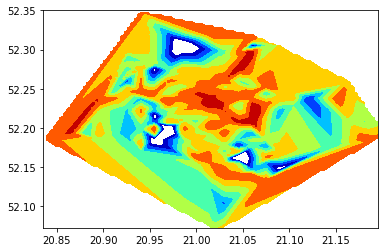

In [240]:
json_dict, df_contour=create_geojson(df_map.lon_mod,df_map.lat_mod,df_map.restaurant_mean_rating,2,30)

In [241]:
df_contour.head()

,Id,value
0,0.0,32.0
1,1.0,34.0
2,2.0,36.0
3,3.0,38.0
4,4.0,40.0


In [244]:
plot_geojson_countour(json_dict, df_contour, "Restaurant mean rating [0-50 scale]", 30, 50)

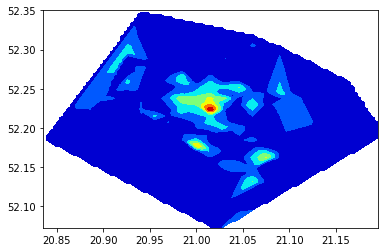

In [268]:
json_dict, df_contour=create_geojson(df_map.lon_mod,df_map.lat_mod,df_map.restaurant_count,10,5)

In [271]:
plot_geojson_countour(json_dict, df_contour, "Restaurant density [restaurants per grid square]", 0, 60)

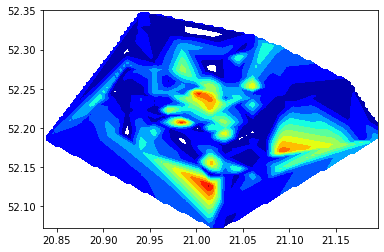

In [274]:
json_dict, df_contour=create_geojson(df_map.lon_mod,df_map.lat_mod,df_map.restaurant_mean_popularity,100,100)

In [279]:
plot_geojson_countour(json_dict, df_contour, "Restaurant popularity [mean ratings count]", 0, 1000)